# Wasserstein GAN

Wasserstein GAN is a development on the famous GAN which avoids vanishing gradient issues by comparing the generated and real data distribution with Earth Mover distance.

For a brief overview, refer to [this](https://paper.dropbox.com/doc/Wasserstein-GAN--AnSk4vkryFmJgICMb_fybpwHAg-GvU0p2V9ThzdwY3BbhoP7).

For a more in-depth discussion, refer this [blogpost](https://www.alexirpan.com/2017/02/22/wasserstein-gan.html) or the [paper](https://arxiv.org/abs/1701.07875).

Here we will implement a WGAN for MNIST.


In practice, there are only really two things that change in WGAN compared to regular GAN :

1.   Instead of having a discriminator, which outputs a probability, we have a critic, which outputs a score. Hence there is no need of sigmoid at the output, and no log in the loss
2.   To ensure that the function represented by the critic is lipschitz, we clip the weights of the critic.



In [0]:
import torch
from torch import nn
from torch.autograd import Variable
from torch.optim import RMSprop
from torchvision import transforms
from torchvision.utils import make_grid
from torchvision.datasets import CIFAR10, MNIST
from pylab import plt
from tqdm import tqdm_notebook
%matplotlib inline

In [2]:
class Config:
    lr = 0.00005
    nz = 100 # noise dimension
    image_size = 64 # we will resize all images to 64*64 using torch.transforms
    nc = 1 # number of channels of the image (1 for MNIST, 3 for CIFAR10)
    ngf = 64 # number of channels of generator
    ndf = 64 # number of channels of discriminator
    batch_size = 32
    max_epoch = 50 # =1 when debug
    gpu = torch.cuda.is_available() # use gpu or not
    clamp_num=0.01 # WGAN gradient clipping parameter
    
opt=Config()
print('Using gpu : ', opt.gpu)

Using gpu :  True


In [0]:
# data preprocess

transform=transforms.Compose([
                transforms.Resize(opt.image_size) ,
                transforms.ToTensor(),
                transforms.Normalize([0.5],[0.5])
                ])

dataset=MNIST(root='.',transform=transform,download=True)
dataloader=torch.utils.data.DataLoader(dataset, opt.batch_size, shuffle = True)

Sauf au dernier layer, on veut $N/2 = (N+2p-k)/s +1$.

On prend $s=2$. Il reste $k=2(p+1)$.

Par exemple, pour $p=1$, on obtient $k=4$

In [0]:
''' REMINDER : nn.Conv2d takes as arguments 
nn.Conv2D(input channels, output channels, kernel_size, stride, padding)

spatial dimension after the convolution is given by  
output_dim = (input_dim + 2*padding - kernel_size) / stride + 1

nn.Conv2d does the exact opposite (upsampling rather than downsampling)
'''

netd = nn.Sequential(
            # layer 1 : spatial dimension 64 -> 32
            nn.Conv2d(opt.nc, opt.ndf, 4, 2, 1,bias=False), 
            nn.LeakyReLU(0.2,inplace=True), 
            
            # layer 2 : spatial dimension 32 -> 16
            nn.Conv2d(opt.ndf,opt.ndf*2, 4, 2, 1, bias=False), 
            nn.BatchNorm2d(opt.ndf*2),
            nn.LeakyReLU(0.2,inplace=True),
            
            # layer 3 : spatial dimension 16 -> 8
            nn.Conv2d(opt.ndf*2,opt.ndf*4, 4, 2, 1, bias=False), 
            nn.BatchNorm2d(opt.ndf*4),
            nn.LeakyReLU(0.2,inplace=True),
            
            # layer 4 : spatial dimension 8 -> 4
            nn.Conv2d(opt.ndf*4,opt.ndf*8, 4, 2, 1, bias=False), 
            nn.BatchNorm2d(opt.ndf*8),
            nn.LeakyReLU(0.2,inplace=True),
            
            # layer 5 : spatial dimension 4 -> 1
            nn.Conv2d(opt.ndf*8, 1, 4, 1, 0,bias=False), 
            # This is a "critic", not a discriminator, so no need of a sigmoid !
        )

netg = nn.Sequential(
            nn.ConvTranspose2d(opt.nz,opt.ngf*8, 4, 1, 0,bias=False),
            nn.BatchNorm2d(opt.ngf*8),
            nn.ReLU(True),
            
            nn.ConvTranspose2d(opt.ngf*8,opt.ngf*4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(opt.ngf*4),
            nn.ReLU(True),
            
            nn.ConvTranspose2d(opt.ngf*4,opt.ngf*2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(opt.ngf*2),
            nn.ReLU(True),
            
            nn.ConvTranspose2d(opt.ngf*2,opt.ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(opt.ngf),
            nn.ReLU(True),
            
            nn.ConvTranspose2d(opt.ngf, opt.nc, 4, 2, 1, bias=False),
            nn.Tanh() 
            # We are outputting images so the output should be in [-1,1] !
        )


def weight_init(m):
    # weight_initialization: important for wgan
    class_name=m.__class__.__name__
    if class_name.find('Conv')!=-1:
        m.weight.data.normal_(0,0.02)
    elif class_name.find('Norm')!=-1:
        m.weight.data.normal_(1.0,0.02)
#     else:print(class_name)

if opt.gpu:
    netd.cuda()
    netg.cuda()

In [0]:
alpha = 0.0002
betas = (0, 0.999)

optimizerD = torch.optim.Adam(netd.parameters(), lr=alpha, betas=betas)
optimizerG = torch.optim.Adam(netg.parameters(), lr=alpha, betas=betas)

In [0]:
# reset the weights
netd.apply(weight_init)
netg.apply(weight_init)
lossD_history = []
lossG_history = []

### Suggest a modification to your previous code to fix this and see how results are affected

In [0]:
# Remember to reset the weights !
netd.apply(weight_init)
netg.apply(weight_init)
lossD_history = []
lossG_history = []

In [0]:
log_every = 1000

opt.max_epoch = 5

def train_modified(every_d=1, every_g=1):
  print('Start training')

  fix_noise = torch.FloatTensor(opt.batch_size,opt.nz,1,1).normal_(0,1) 
  # we will see how the generator reconstructs this noise every 100 steps
  if opt.gpu:
      fix_noise = fix_noise.cuda()

  for epoch in range(opt.max_epoch):
      print("EPOCH : {}".format(epoch))
      for ii, data in enumerate(dataloader):
        if ii%every_d==0:
          # ----- train netd -----
          z = torch.empty(len(data[0]),opt.nz,1,1).normal_().cuda()
          fake = netg(z)
          D_scores_on_real = netd(torch.tensor(data[0].cuda()))
          D_scores_on_fake = netd(fake)
          lossD = torch.mean(D_scores_on_fake - D_scores_on_real)
          optimizerD.zero_grad()
          lossD.backward()
          optimizerD.step()
          for p in netd.parameters():
            p.data.clamp_(-opt.clamp_num, opt.clamp_num)

        if ii%every_g==0:
          # ------ train netg -------
          z = torch.empty(opt.batch_size,opt.nz, 1, 1).normal_().cuda()
          fake = netg(z)
          D_scores_on_fake = netd(fake)
          lossG = -torch.mean(D_scores_on_fake)
          optimizerG.zero_grad()
          lossG.backward()
          optimizerG.step()

        # log every 100 steps
        if ii%log_every==0:
          lossG_history.append(lossG)
          lossD_history.append(lossD)
          print('LossD = {}, LossG = {}'.format(lossD, lossG))
          fake = netg(fix_noise)
          imgs = make_grid(fake.data*0.5+0.5).cpu() 
          plt.imshow(imgs.permute(1,2,0).numpy()) 
          plt.show()
          
  return
 

Pour MNIST, il faut augmenter la fréquence relative de mise à jour du générateur.

Start training
EPOCH : 0


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:20: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


LossD = 0.7057849764823914, LossG = 0.0007936775218695402


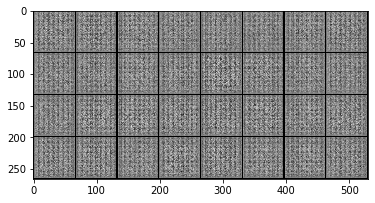

LossD = -0.35529112815856934, LossG = -0.1329319179058075


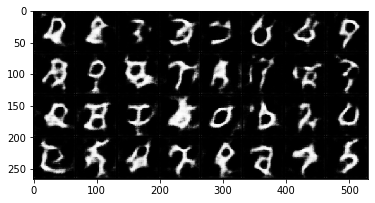

EPOCH : 1
LossD = -0.37342333793640137, LossG = 0.4738118052482605


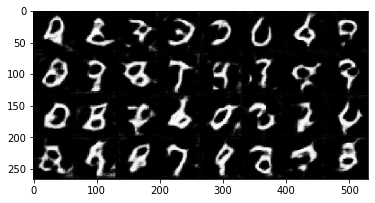

LossD = -0.5674912929534912, LossG = 0.21537187695503235


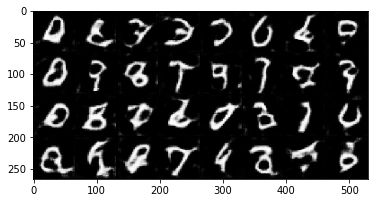

EPOCH : 2
LossD = -0.4764680564403534, LossG = 0.508484959602356


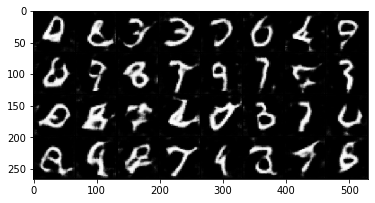

In [0]:
%%time
train_modified(every_g=2)

In [0]:
plt.plot(lossG_history, label='Generator')
plt.plot(lossD_history, label='Discriminator')
plt.legend()

In [0]:
noise = torch.randn(64,opt.nz,1,1)
if opt.gpu:
  noise = noise.cuda()
fake=netg(noise)
imgs = make_grid(fake.data*0.5+0.5).cpu()
plt.figure(figsize=(10,10))
plt.imshow(imgs.permute(1,2,0).numpy())
plt.show()